In [127]:
import warnings
warnings.filterwarnings("ignore")
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numba
from numba import njit
from sklearn.linear_model import LinearRegression
import random
from joblib import Parallel, delayed
from scipy import stats
from matplotlib.gridspec import GridSpec

np.random.seed(42)
random.seed(42)

### Параметры и настройки

In [21]:
n_sim = 1000
gamma = 0.1
T_norm = 1.0  # нормированное время

### Калибровка параметров 

In [49]:
# данные для калибровки параметров
sol = pd.read_parquet(r'C:\Users\Эвелина Новикова\Documents\Downloads\binance-futures_book_snapshot_25_2024-11-01_SOLUSDT.parquet')
sol['local_timestamp'] = pd.to_datetime(sol['local_timestamp'], unit='us')
sol['spread'] = sol['asks[0].price'] - sol['bids[0].price']
sol['delta'] = sol['spread'] / 2
sol['time_diff'] = sol['local_timestamp'].diff().dt.total_seconds()
sol = sol.dropna()

In [51]:
grouped = sol.groupby('delta')
deltas, rates = [], []

for delta, group in grouped:
    total_time = group['time_diff'].sum()
    count = len(group)
    if total_time > 0:
        rate = count / total_time
        deltas.append(delta)
        rates.append(rate)

deltas = np.array(deltas)
log_rates = np.log(rates)

reg = LinearRegression()
reg.fit(deltas.reshape(-1, 1), log_rates)
k = abs(reg.coef_[0])
A = np.exp(reg.intercept_)

print(f"Калиброванный A: {A:.4f}, k: {k:.4f}")

Калиброванный A: 18.7857, k: 0.0978


In [53]:
# ресемплированные данные для симуляций
df1 = pd.read_parquet(r'C:\Users\Эвелина Новикова\100ms.parquet')
df2  = pd.read_parquet(r'C:\Users\Эвелина Новикова\pa_model_results.parquet')
mid_price = df2['predicted_mid_t'].values
sol_100ms = df1['SOL'].values

d_log = np.diff(np.log(sol_100ms))
sigma = np.std(d_log)
print(f"Estimated sigma: {sigma:.6f}")

Estimated sigma: 0.000032


### Модельная сетка

In [55]:
N = len(mid_price) - 1
if N < 1:
    raise ValueError("Недостаточно точек для симуляции.")
dt = T_norm / N
print(f"Model grid: N={N}, dt={dt:.6e}")

Model grid: N=863920, dt=1.157515e-06


### Оптимальный спред

In [57]:
spread_opt = 2.0 / gamma * np.log(1 + gamma / k)
print(f"Оптимальный спред: {spread_opt:.6f}")

Оптимальный спред: 14.084551


In [59]:
N = len(mid_sec) - 1
if N < 1:
    raise ValueError("Недостаточно точек mid_sec для симуляции")
dt = T_norm / N
print(f"Model grid: N={N}, dt={dt:.6e}")

spread_opt = 2.0 / gamma * np.log(1 + gamma / k)

Model grid: N=863988, dt=1.157423e-06


### Оптимизированная симуляция одной траектории

In [87]:
def single_simulation(seed, mid_price, sigma, A, k, gamma, dt, T_norm, N, spread_opt):
    try:
        rng = np.random.default_rng(seed)
        q = np.zeros(N+1)
        x = np.zeros(N+1)
        pnl = np.zeros(N+1)
        if np.isscalar(mid_price):
            mid_price_val = mid_price
        else:
            if len(mid_price) <= N:
                mid_price_val = mid_price[min(N, len(mid_price)-1)]
            else:
                mid_price_val = mid_price[N]

        for n in range(N):
            r = mid_price_val - q[n] * gamma * sigma**2 * (T_norm - n * dt)
            ra = r + spread_opt / 2
            rb = r - spread_opt / 2

            delta_a = ra - mid_price_val
            delta_b = mid_price_val - rb
            lambda_a = A * np.exp(-k * delta_a)
            lambda_b = A * np.exp(-k * delta_b)

            prob_a = 1 - np.exp(-lambda_a * dt)
            prob_b = 1 - np.exp(-lambda_b * dt)

            dA = rng.random() < prob_a
            dB = rng.random() < prob_b

            q[n+1] = q[n] - dA + dB
            x[n+1] = x[n] + ra * dA - rb * dB
            pnl[n+1] = x[n+1] + q[n+1] * mid_price_val

        return pnl[-1], q, x, pnl
        
    except Exception as e:
        print(f"Ошибка в симуляции с seed {seed}: {e}")
        return None

### Обёртка для параллельного запуска

In [91]:
def run_simulations_paralleled(mid_price, sigma, A, k, gamma, dt, T_norm, N, n_sim, n_jobs=-1):
    print(f"Параметры: N={N}, n_sim={n_sim}, mid_price_type={type(mid_price)}")
    
    if np.isscalar(mid_price):
        print(f"mid_price является скаляром: {mid_price}")
    else:
        print(f"mid_price является массивом длины: {len(mid_price)}")
    
    seeds = np.arange(n_sim)
    
    try:
        results = Parallel(n_jobs=n_jobs, verbose=10)(
            delayed(single_simulation)(
                int(seed), mid_price, sigma, A, k, gamma, dt, T_norm, N, spread_opt
            ) for seed in seeds
        )
        print("Параллельное выполнение завершено успешно")
        
    except Exception as e:
        print(f"Критическая ошибка при выполнении параллельных симуляций: {e}")
        print(f"Тип ошибки: {type(e).__name__}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

    if not results or any(r is None for r in results):
        print("Ошибка: некоторые результаты симуляций None")
        return None, None, None, None

    pnl_final = np.empty(n_sim)
    q_last = None
    x_last = None
    pnl_last = None

    for i, result in enumerate(results):
        if result is None:
            print(f"Результат симуляции {i} равен None")
            continue
            
        pnl, q, x, pnl_hist = result
        pnl_final[i] = pnl
        
        if i == n_sim - 1:  
            q_last = q
            x_last = x
            pnl_last = pnl_hist
            print(f"Последняя симуляция сохранена: q_last shape={q.shape}")

    return pnl_final, q_last, x_last, pnl_last

### Запуск симуляций

In [93]:
try:
    pnl_final_1, q_last_1, x_last_1, pnl_last_1 = run_simulations_paralleled(
        mid_price=mid_price,
        sigma=sigma,
        A=A,
        k=k,
        gamma=gamma,
        dt=dt,
        T_norm=T_norm,
        N=N,
        n_sim=n_sim,
        n_jobs=-1
    )
    
    if q_last_1 is None:
        print(" q_last is None")
        test_result = single_simulation(0, mid_price, sigma, A, k, gamma, dt, T_norm, N, spread_opt)
        print(f"Тестовая симуляция: {test_result}")
        
except Exception as e:
    print(f"Ошибка при вызове run_simulations_parallel: {e}")

Параметры: N=863988, n_sim=1000, mid_price_type=<class 'numpy.ndarray'>
mid_price является массивом длины: 863921


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Параллельное выполнение завершено успешно
Последняя симуляция сохранена: q_last shape=(863989,)


### Анализ

In [109]:
mean_pnl = np.mean(pnl_final_1)
std_pnl = np.std(pnl_final_1)
stderr_pnl = std_pnl / np.sqrt(n_sim)
print(f"Число симуляций: {n_sim}")
print(f"Средний PnL: {mean_pnl}")
print(f"Стандартное отклонение PnL: {std_pnl}")
print(f"Стандартная ошибка среднего: {stderr_pnl}")

Число симуляций: 1000
Средний PnL: 133.37365830229146
Стандартное отклонение PnL: 30.736349852852886
Стандартная ошибка среднего: 0.9719687249479634


### Визуализация

In [99]:
r_arr = np.zeros(N+1)
ra_arr = np.zeros(N+1)
rb_arr = np.zeros(N+1)


for n in range(min(N, len(mid_price), len(q_last_1))):
    r_arr[n] = mid_price[n] - q_last_1[n] * gamma * sigma**2 * (T_norm - n * dt)
    ra_arr[n] = r_arr[n] + spread_opt / 2
    rb_arr[n] = r_arr[n] - spread_opt / 2

if N > 0:
    r_arr[-1] = r_arr[-2] if N > 1 else r_arr[0]
    ra_arr[-1] = ra_arr[-2] if N > 1 else ra_arr[0]
    rb_arr[-1] = rb_arr[-2] if N > 1 else rb_arr[0]

max_q_held = np.max(q_last_1)
min_q_held = np.min(q_last_1)

print("\nПоследняя симуляция:")
print(f"Итоговый инвентарь: {q_last_1[-1]}")
print(f"Последняя цена: {mid_price[-1]}")
print(f"Кэш: {x_last_1[-1] if 'x_last_1' in locals() else 'N/A'}")
print(f"Итоговое состояние: {pnl_last_1[-1]}")
print(f"Максимальный инвентарь: {max_q_held}")
print(f"Минимальный инвентарь: {min_q_held}")


Последняя симуляция:
Итоговый инвентарь: -1.0
Последняя цена: 166.0338622689789
Кэш: 285.7525481095173
Итоговое состояние: 119.7186858405384
Максимальный инвентарь: 2.0
Минимальный инвентарь: -1.0


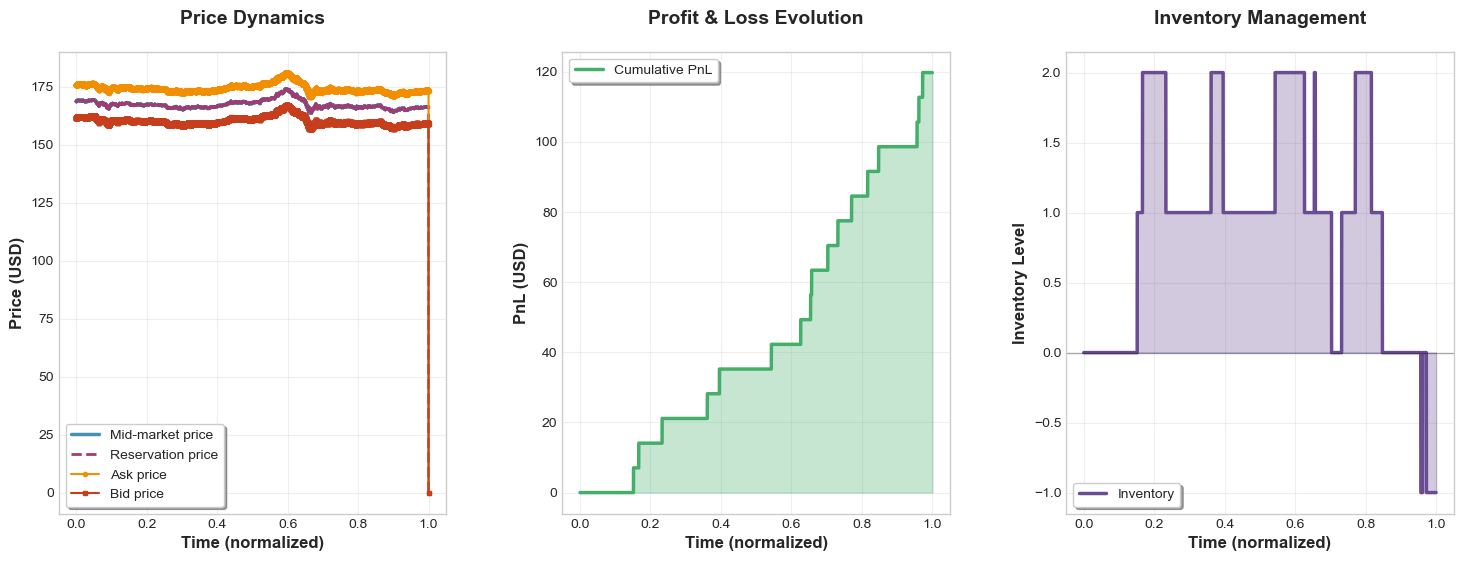

In [117]:
plt.style.use('seaborn-v0_8-whitegrid')  
fig = plt.figure(figsize=(18, 6), dpi=100)
gs = GridSpec(1, 3, figure=fig, wspace=0.3)

colors = {
    'mid_price': '#2E86AB',     
    'reservation': '#A23B72',    
    'ask': '#F18F01',           
    'bid': '#C73E1D',          
    'pnl': '#44AF69',          
    'inventory': '#6A4C93'     
}


ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(t[:len(mid_price)], mid_price[:len(t)], 
         color=colors['mid_price'], linewidth=2.5, label='Mid-market price', alpha=0.9)
ax1.plot(t, r_arr[:len(t)], 
         color=colors['reservation'], linewidth=2.0, label='Reservation price', linestyle='--')
ax1.plot(t, ra_arr[:len(t)], 
         color=colors['ask'], linewidth=1.5, label='Ask price', marker='o', markersize=3, markevery=50)
ax1.plot(t, rb_arr[:len(t)], 
         color=colors['bid'], linewidth=1.5, label='Bid price', marker='s', markersize=3, markevery=50)

ax1.set_xlabel('Time (normalized)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Price (USD)', fontsize=12, fontweight='bold')
ax1.legend(frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.3)
ax1.set_title('Price Dynamics', fontsize=14, fontweight='bold', pad=20)


ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(t, pnl_last_1, 
         color=colors['pnl'], linewidth=2.5, label='Cumulative PnL')
ax2.fill_between(t, pnl_last_1, alpha=0.3, color=colors['pnl'])

ax2.set_xlabel('Time (normalized)', fontsize=12, fontweight='bold')
ax2.set_ylabel('PnL (USD)', fontsize=12, fontweight='bold')
ax2.legend(frameon=True, fancybox=True, shadow=True)
ax2.grid(True, alpha=0.3)
ax2.set_title('Profit & Loss Evolution', fontsize=14, fontweight='bold', pad=20)


ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(t, q_last_1, 
         color=colors['inventory'], linewidth=2.5, label='Inventory')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
ax3.fill_between(t, q_last_1, alpha=0.3, color=colors['inventory'])

ax3.set_xlabel('Time (normalized)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Inventory Level', fontsize=12, fontweight='bold')
ax3.legend(frameon=True, fancybox=True, shadow=True)
ax3.grid(True, alpha=0.3)
ax3.set_title('Inventory Management', fontsize=14, fontweight='bold', pad=20)


plt.tight_layout()
plt.show()

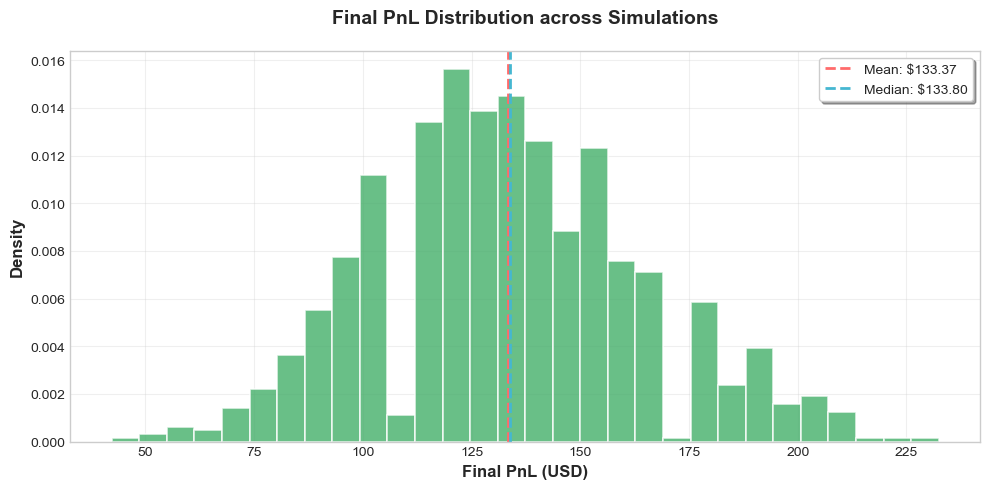

In [131]:
if 'pnl_final_1' in locals() and pnl_final_1 is not None:
    fig2, ax4 = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
    
    mean_pnl = np.mean(pnl_final_1)
    median_pnl = np.median(pnl_final_1)
    std_pnl = np.std(pnl_final_1)
    
    n, bins, patches = ax4.hist(pnl_final_1, bins=30, 
                               color='#44AF69', 
                               edgecolor='white', 
                               linewidth=1.2,
                               alpha=0.8,
                               density=True)
    
    ax4.axvline(mean_pnl, color='#FF6B6B', linestyle='--', linewidth=2, 
                label=f'Mean: ${mean_pnl:.2f}')
    ax4.axvline(median_pnl, color='#45B7D1', linestyle='--', linewidth=2,
                label=f'Median: ${median_pnl:.2f}')
    
    ax4.set_xlabel('Final PnL (USD)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Density', fontsize=12, fontweight='bold')
    ax4.set_title('Final PnL Distribution across Simulations', 
                 fontsize=14, fontweight='bold', pad=20)
    ax4.legend(frameon=True, fancybox=True, shadow=True)
    ax4.grid(True, alpha=0.3)
    


    
    plt.tight_layout()
    plt.show()

### Результаты

In [125]:
sharpe_ratio = mean_pnl / std_pnl if std_pnl > 0 else 0
max_drawdown = np.min(pnl_last_1) - np.max(pnl_last_1) if len(pnl_last_1) > 0 else 0
avg_inventory = np.mean(np.abs(q_last_1))
skewness = stats.skew(pnl_final_1) if len(pnl_final_1) > 0 else 0
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Максимальная просадка: {max_drawdown:.2f}")
print(f"Средний абсолютный инвентарь: {avg_inventory:.2f}")
print(f"Асимметрия распределения: {skewness:.2f}")

Sharpe Ratio: 4.34
Максимальная просадка: -119.72
Средний абсолютный инвентарь: 0.93
Асимметрия распределения: 0.24
